In [1]:
# torch and visulization
from tqdm             import tqdm
import torch.optim    as optim
from torch.optim      import lr_scheduler
from torchvision      import transforms
from torch.utils.data import DataLoader
from model.parse_args_train import  parse_args

# metric, loss .etc
from model.utils import *
from model.metric import *
from model.loss import *
from model.load_param_data import  load_dataset, load_param

# model
from model.model_DNANet import  Res_CBAM_block
from model.model_DNANet import  DNANet

Text(0, 0.5, 'SIGMα')

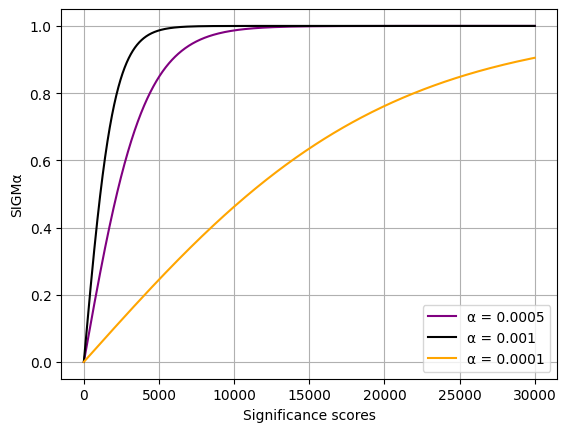

In [2]:
# SIGMAα activation function (Ntest=1)
from model.model_DeepNFA import SIGMalpha

sigma1 = SIGMalpha(0.0005)
sigma2 = SIGMalpha(0.001)
sigma3 = SIGMalpha(0.0001)

x = torch.arange(0,30001).unsqueeze(1).unsqueeze(1)

y1 = sigma1(x)
y2 = sigma2(x)
y3 = sigma3(x)

plt.plot(x.squeeze(), y1.squeeze(), c='purple', label='α = 0.0005')
plt.plot(x.squeeze(), y2.squeeze(), c='black', label='α = 0.001')
plt.plot(x.squeeze(), y3.squeeze(), c='orange', label='α = 0.0001')
plt.legend()
plt.grid()
plt.xlabel('Significance scores')
plt.ylabel('SIGMα')

Text(0, 0.5, 'Significance score')

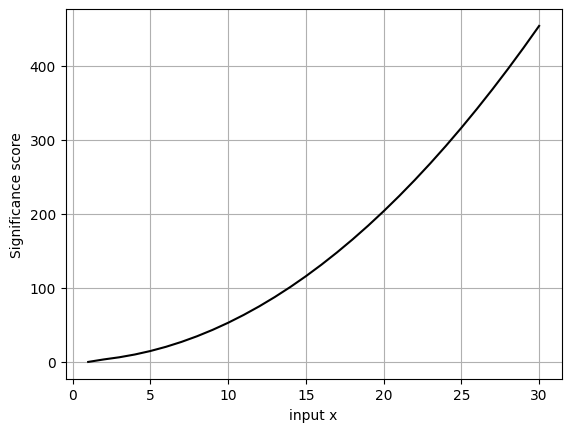

In [3]:
# Significance
from model.model_DeepNFA import Significance

signif = Significance()

x = torch.arange(0,31).unsqueeze(1).unsqueeze(1).unsqueeze(1)
y = signif(x)

plt.plot(x.squeeze(), y.squeeze(), c='black')
plt.grid()
plt.xlabel('input x')
plt.ylabel('Significance score')

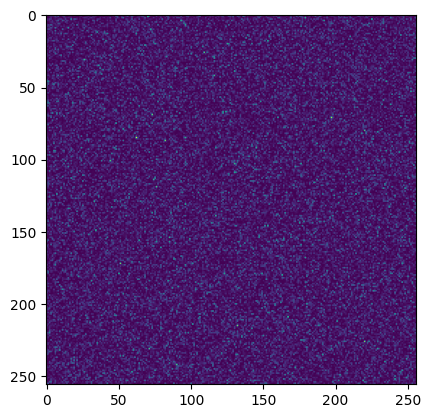

In [4]:
x = torch.randn((1, 8, 256, 256))

plt.imshow(signif(x)[0])

In [15]:
class ECABlock(nn.Module):
    def __init__(self, k_size=3):
        super(ECABlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)
        print(y.shape)
        print(y.squeeze(-1).transpose(-1, -2).shape)
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)
        print(y.shape)
        y = self.sigmoid(y)
        print(y.expand_as(x).shape)
        return x * y.expand_as(x), y

In [16]:
eca_block = ECABlock()

x = torch.randn((32, 5, 256, 256))

x, y = eca_block(x)

torch.Size([32, 5, 1, 1])
torch.Size([32, 1, 5])
torch.Size([32, 5, 1, 1])
torch.Size([32, 5, 256, 256])


In [18]:
y[0]

tensor([[[0.5002]],

        [[0.5002]],

        [[0.4993]],

        [[0.5003]],

        [[0.5003]]], grad_fn=<SelectBackward0>)